### Overview

This tutorial demonstrates how to use Longcell to analyze single cell isoform count data. Due to the frequent truncations in Nanopore long reads sequencing and to allow for identification of new ioforms, Longcell stores the isoform information as sequence of splicing sites. So instead of building a cell-by-isoform matrix, Longcell reveal alternative splicing events on the splicing sites level. But the cell-by-isoform matrix is also provided for regular single cell RNA seq analysis,like cell type clustering. 

The general steps for the analysis are:

1. regular scRNA-seq gene/isoform expression analysis.

2. identify highly variable splicing sites.

3. differetial alternative splicing analysis between cell groups

First, we load Longcell and the other packages necessary for this vignette.

In [79]:
options(future.globals.maxSize= 1024*1024^2)

In [33]:
library(Longcell)
library(Seurat)
library(dplyr)
library(future)
library(future.apply)

### annotation

In [39]:
annotLookup = readRDS("~/Upenn//Thesis//project//Single-cell-Long-reads/annotation/human/annotLookup.rds")

In [2]:
gene_bed = readRDS("../inst/extdata//annotation//gene_bed.rds")
gtf = readRDS("../inst/extdata//annotation//exon_gtf.rds")

### data overview

Here we are using the sample of colorecatal metastasis to liver published in our paper as an example. The single cell isoform quantification for this sample is generated by LongcellPre.

In [3]:
mat = readRDS("../inst/extdata//data//sc_iso_mat.rds")

We can generate a Seurat object based on the cell by isoform matrix, just in the same way as the cell by gene matrix.

In [4]:
iso_mat = mat %>% filter(isoform != "unknown") %>% select(-gene)
rownames(iso_mat) = iso_mat$isoform
iso_mat = iso_mat %>% select(-isoform)

In [5]:
crc = CreateSeuratObject(counts = iso_mat,project = "isoform",min.cells = 3,min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


In [6]:
crc

An object of class Seurat 
18734 features across 236 samples within 1 assay 
Active assay: RNA (18734 features, 0 variable features)
 1 layer present: counts

We can first do general single cell analysis via regular Seurat process to get the cell cluster information

In [7]:
suppressWarnings({
    crc <-  crc %>%
    SCTransform(method = "glmGamPoi", verbose = FALSE) %>%
    RunPCA(npcs = 30, verbose = FALSE) %>%
    RunUMAP(reduction = "pca", dims = 1:20,n.neighbors = 30,verbose = FALSE)
})

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



Here we directly use the cell type annotation we get from marker genes to annotate cell clusters.

In [8]:
cell_type = read.table("../inst/extdata/data/cell_type.txt",header = TRUE)
rownames(cell_type) = cell_type$cell
crc$type = cell_type[colnames(crc),"type"]

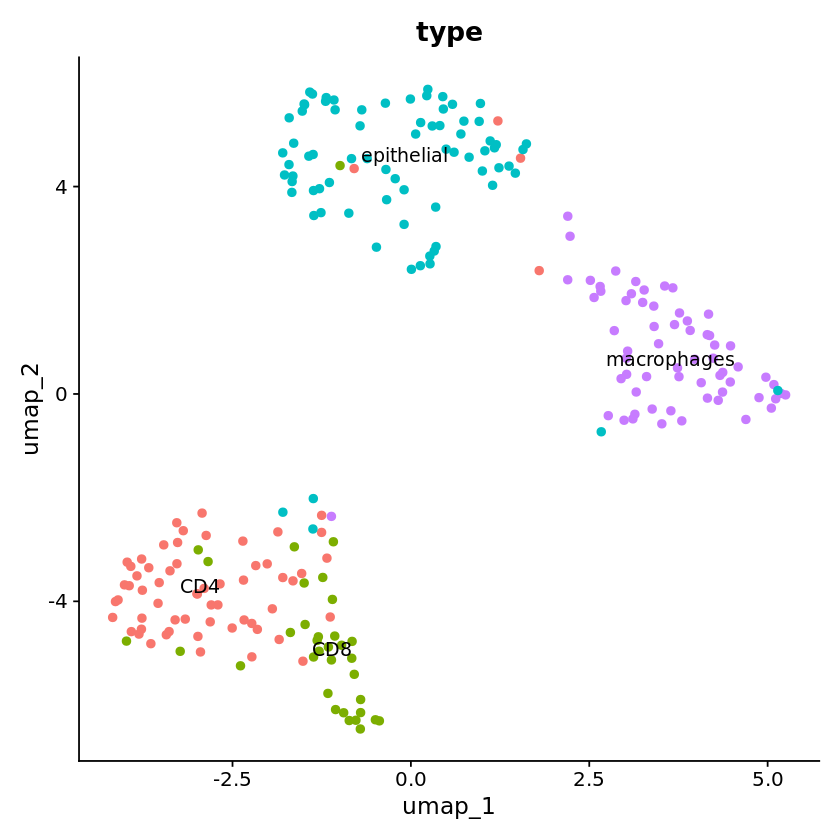

In [9]:
DimPlot(crc, reduction = "umap", group.by = "type",label = TRUE,pt.size = 2)+NoLegend()

### Single cell heterogeneity of alterative splicing

After we take a glance on the data, we can start to explore the alternative splicing within the cell population. Longcell detect the alternative splicing event at the splice site level.We first read in the data for the downstream analysis.

In [10]:
iso = readRDS("../inst/extdata/data/sc_iso_count.rds")

Each read here is stored as $s_1,e_1|s_2,e_2|...$, in which $s_i$ means the start position of the exon $i$ while $e_i$ means the end position.

We first build a Splice object based on this data.

In [11]:
crc_splice = creatSplice_from_df(iso)

The isoform sequences and expression can be revisted from the Splice object by `getIsoform()`

In [22]:
temp = getIsoform(crc_splice,c("MYL6","RPS24"))

In [23]:
head(temp)

,cell,gene,isoform,count,polyA
,<chr>,<chr>,<chr>,<dbl>,<dbl>
575755,AAACGGGGTTATGTGC,RPS24,"78033859,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040615,78040692",0.1904762,1.0000000
575756,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78035580",0.3333333,0.0000000
575757,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040694",3.3333333,0.9914286
575758,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040695",1.3333333,1.0000000
575759,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040696",1.6666667,0.9898305
575760,AAACGGGGTTATGTGC,RPS24,"78033863,78033904|78035352,78035417|78035511,78035720|78037194,78037304|78040204,78040225|78040615,78040697",6.0000000,0.9949483


As isoform count is even sparser than the gene count, we can only get confident alternative splicing signals from high expression genes, thus we can filter out lowly expressed genes to save the computing time.

In [29]:
heg = HighExprsGene(crc_splice,thresh = 500)
head(heg)
length(heg)

[1] "ABRACL" "ACTB"   "ACTG1"  "ACTN4"  "AGR2"   "AIF1"

[1] 752

Here 752 genes would be preserved for downstream $\phi$ calculation. And before that, we can first merge splicing sites which are always coexisting or mutually exclusive as meta splicing sites, as they contain the same information. Through this step we can further decrease the computation burden. The parameter `eps` can be adjusted to indicate how aggressive the merging process would be.Higher `eps` leads to more aggressive merge, but may be more possible to lead to information loss.

In [64]:
plan(strategy = "multisession",workers = 8)
crc_splice = geneSiteTable(crc_splice,gene_bed,genes = heg,eps = 0.05)

[1] "PARK7"
[1] "MICOS10"
[1] "CDC42"
[1] "RPL11"
[1] "SRRM1"
[1] "TMEM50A"
[1] "SH3BGRL3"
[1] "CD52"
[1] "HMGN2"
[1] "SFN"
[1] "ATP5IF1"
[1] "NDUFS5"
[1] "YBX1"
[1] "ATP6V0B"
[1] "RPS8"
[1] "UQCRH"
[1] "SCP2"
[1] "SRSF11"
[1] "RPL5"
[1] NA
[1] "ATP5PB"
[1] "MRPS21"
[1] "S100A9"
[1] "LMNA"
[1] "UFC1"
[1] "FCER1G"
[1] "MGST3"
[1] "PRRC2C"
[1] "PRDX6"
[1] "RGS1"
[1] "PTPRC"
[1] "ELF3"
[1] "BTG2"
[1] "G0S2"
[1] "ATF3"
[1] "ARF1"
[1] "GUK1"
[1] "RPL22"
[1] "ENO1"
[1] "CAPZB"
[1] "LAPTM5"
[1] "MARCKSL1"
[1] "PABPC4"
[1] "SLC2A1"
[1] "PRDX1"
[1] NA
[1] "MAGOH"
[1] "TMEM59"
[1] "TACSTD2"
[1] "JUN"
[1] "SERBP1"
[1] "GNG5"
[1] "RPL7P9"
[1] "LAMTOR5"
[1] "RHOC"
[1] "CSDE1"
[1] "TXNIP"
[1] "MCL1"
[1] "CTSS"
[1] "S100A10"
[1] "S100A11"
[1] "S100A8"
[1] "S100A6"
[1] "S100A4"
[1] "S100A14"
[1] "TPM3"
[1] "KRTCAP2"
[1] "SSR2"
[1] "CRABP2"
[1] "TAGLN2"
[1] "PFDN2"
[1] "TMCO1"
[1] "GAS5"
[1] "GLUL"
[1] "TOMM20"
[1] "HNRNPU"
[1] "RHOB"
[1] "PPP1CB"
[1] "YPEL5"
[1] "EML4"
[1] "EPCAM"
[1] "RPS27A"
[1] "PC

In [131]:
source("../R/spliceOb.R")
source("../R/splice_table.R")

In [118]:
cell = rownames(crc_splice@meta_sites[["ABRACL"]]@cellGeneCount)

In [132]:
plan(strategy = "multisession",workers = 2)
#plan(strategy = "sequential")
test = geneSiteTable.base(crc_splice,gene_bed,genes = heg[1:10],eps = 0.05,overwrite = TRUE)

[1] "ANKRD37"
[1] "AIF1"
[1] "ABRACL"
[1] "ACTB"
[1] "AGR2"
[1] "ALOX5AP"
[1] "AKAP13"
[1] "ANAPC11"
[1] "ACTG1"
[1] "ACTN4"


In [89]:
saveRDS(crc_splice,"../inst/extdata//data/crc_splice.rds")

The merged splicing sites are saved in a `metaSite` object, for example:

In [65]:
getMetaSites(crc_splice,"MYL6")

metaSite object with  225  cells and  4 meta splicing sites, which are merged from  25 original splicing sites.
The head of the gene count matrix for each meta site is:
                 metasite_1 metasite_2 metasite_3 metasite_4
AAACGGGGTTATGTGC         29         28         29         29
AACCATGAGCCACGCT          5          4          5          5
AACCATGCAAGCCTAT          6          5          5          5
AACTCTTCAAGTAATG          3          2          3          2
AAGACCTAGCTGAAAT          2          1          2          2
AAGACCTTCAAACGGG         12          9         12         12
The head of the spliced in count matrix for each meta site is:
                 metasite_1 metasite_2 metasite_3 metasite_4
AAACGGGGTTATGTGC         29         28         29          2
AACCATGAGCCACGCT          5          4          5          0
AACCATGCAAGCCTAT          6          5          5          0
AACTCTTCAAGTAATG          3          2          2          2
AAGACCTAGCTGAAAT          2         

The `metaSite` object maintains two matrices, one records the gene count for each meta splice site and the other records the spliced-in count. The correspondence between the meta sites and original sites is also recorded in it.

After we generate the meta splicing sites, we can estimate the ratio of inter-cell heterogeneity for each meta site.

In [83]:
source("../R/phi.R")

In [86]:
temp = geneSitesPhi_from_beta(crc_splice,"MYL6")

ERROR: Error in mle_bb(exon_count, gene_count): could not find function "mle_bb"


In [88]:
#plan(strategy = "multisession",workers = 2)
plan(strategy = "sequential")
crc_phi = genesSitesPhi.base(crc_splice,genes = "MYL6",method = "beta")

Error in mle_bb(exon_count, gene_count) : 
  could not find function "mle_bb"
The phi estimation failed for the gene  MYL6 !


In [82]:
crc_phi

<0 x 0 matrix>

We can then show all valid $\phi$ estimation with small confidence interval in a $\phi$ vs. $\bar{\psi}$ scatter plot

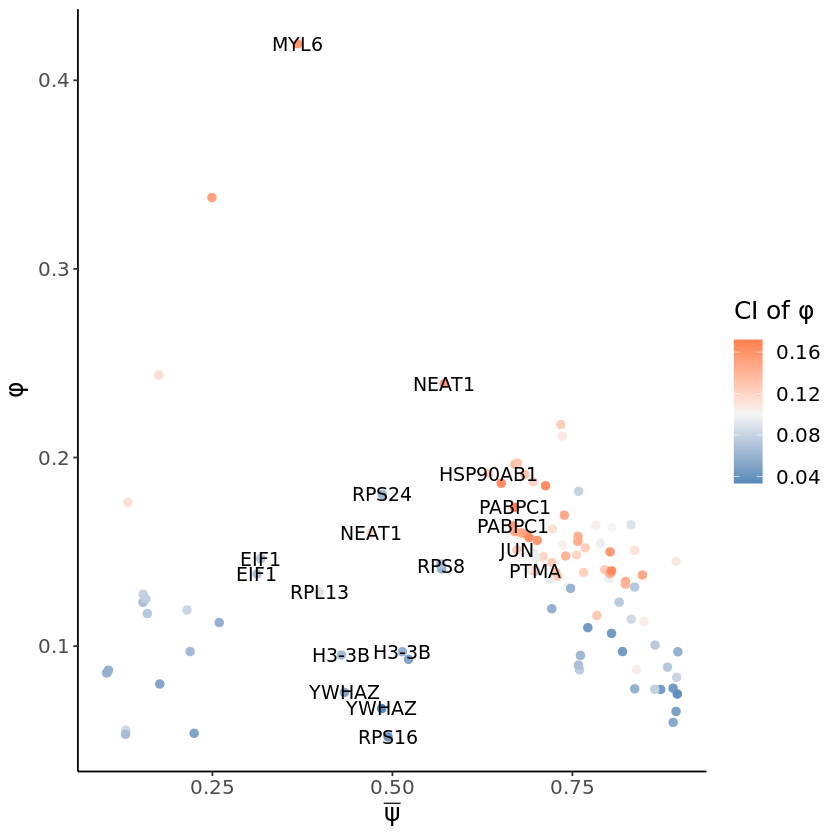

In [18]:
phiPlot(crc_phi,annot_col = "gene",midpoint = 0.1)

We could order the $\phi$ for each exon in a decreasing order, and the top list should be highly variable exons.

In [19]:
head(crc_phi[order(crc_phi$phi,decreasing = TRUE),])

,gene,exon,mean_psi,phi,phi_lwr,phi_upr,count,phi_conf
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
367,MYL6,35,0.3684847,0.4193560,0.3428386,0.5002458,47,0.1574072
1135,SAT1,9,0.2493341,0.3378175,0.2669417,0.4188943,78,0.1519526
1136,SAT1,10,0.1751983,0.2438151,0.1921018,0.3065058,78,0.1144040
399,NEAT1,39,0.5719830,0.2391154,0.1604946,0.3183297,36,0.1578351
1141,SAT1,16,0.7338286,0.2174359,0.1576851,0.2821809,81,0.1244958
1143,SAT1,18,0.7362526,0.2112682,0.1521604,0.2594070,81,0.1072465


Here we use the highest one MYL6 exon35 as an example, we could first show its single cell $\psi$ distribution:

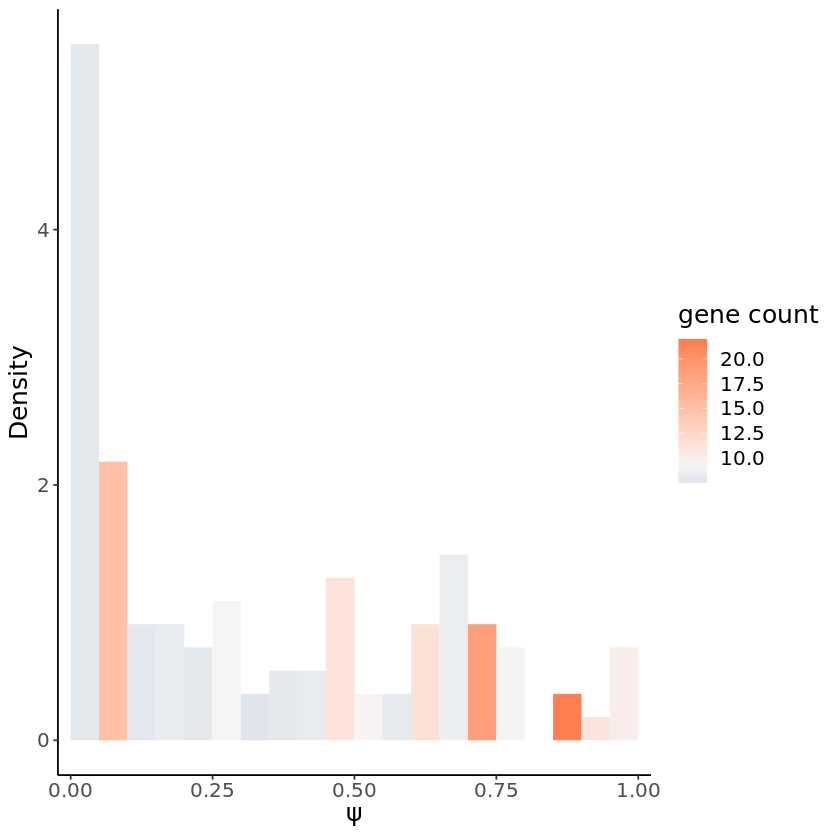

In [20]:
psiHist(crc,gene = "MYL6",exon = "35")

[[1]]


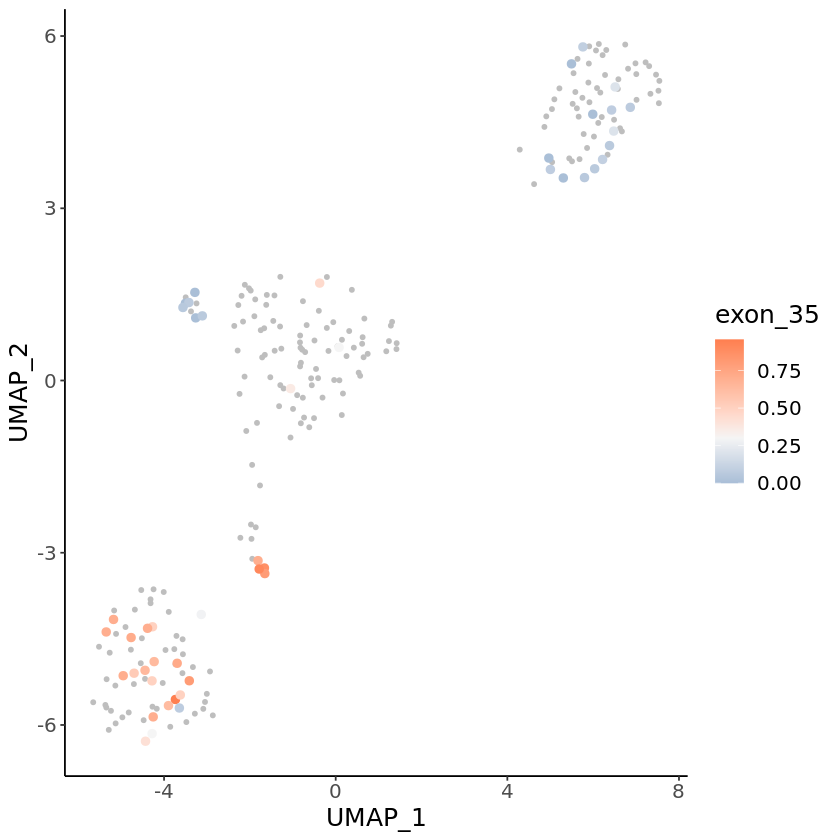

In [21]:
psiCellPlot(crc,gene = "MYL6",exons = "35",cell_embedding = "umap")

We could see very different alternative splicing patterns for this exon in epithlials and other immune cells. Epithlials highly spliced in the exon 35 in MYL6, while T cells and macrophages tend to splice this exon out.

### Generalized Likelihood Ratio Test

Since we have found the splicing heterogeneity between epithelials and immune cells, here we could do a differential alternative splicig analysis between the two cell groups to see if they have other more splicing difference.

We first specify the non-epithelial cells as immune cells in the cell type annotation

In [22]:
crc$group = ifelse(crc$type == "epithelial","epithelial","immune")

Then we could do generalized likelihood ratio test for highly expressed genes for immune cells and epithelials to see if they have alternative splicing difference.

In [33]:
crc_GLRT_sig = genes_groups_GLRT(crc,genes = heg,
                              group1s = "epithelial",group2s = "immune",group_col = "group",
                              gene_bed = gene_bed,gtf = gtf,q_thresh = 0.05,cores = 8)

The job will be paralleled on  8  cores.


Compared to epthelials, most exons show decreasing splice-in in immune cells as most of them show negative mean change.

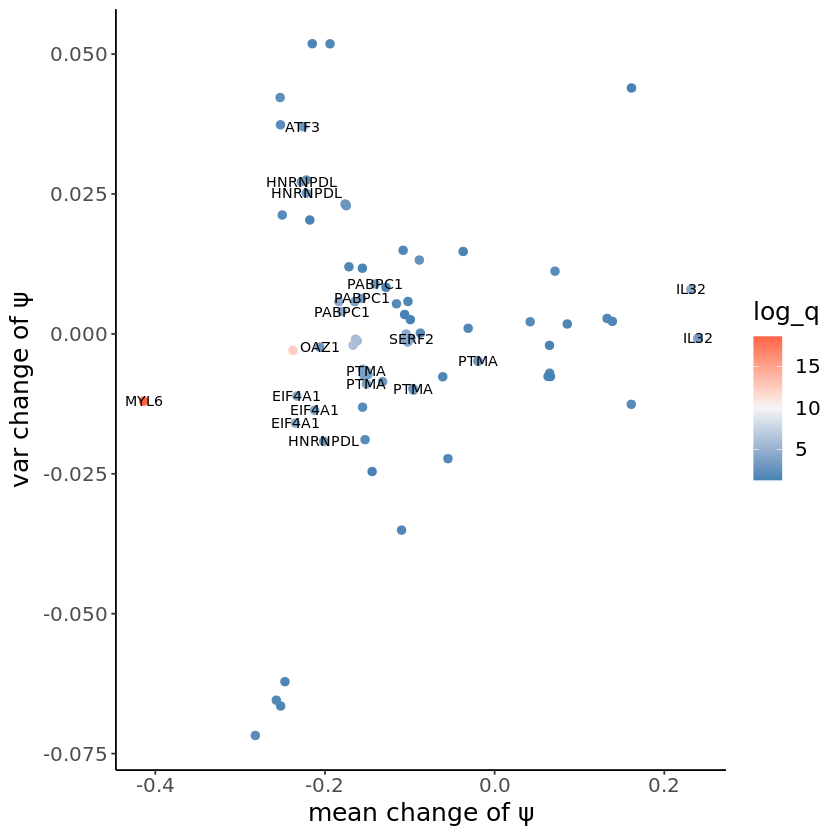

In [84]:
GLRT_sig_plot(crc_GLRT_sig)

In [40]:
head(crc_GLRT_sig[order(crc_GLRT_sig$q),])

,gene,group1,group2,exon,p,alpha1,beta1,alpha2,beta2,q,mean_diff,var_diff
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
633,MYL6,epithelial,immune,35,2.309757e-22,4.585580,3.364490,1.296922,6.654382,2.556901e-19,-0.4136894,-0.0120241663
913,RPS24,epithelial,immune,31,6.644542e-16,6.683290,3.766842,5.211762,7.757096,3.677754e-13,-0.2376737,-0.0029256764
924,RPS8,epithelial,immune,26,2.079360e-09,8.228405,4.128133,8.025231,8.055760,7.672839e-07,-0.1668643,-0.0020203249
923,RPS8,epithelial,immune,25,5.550707e-09,8.273600,4.109817,7.561798,7.435223,1.536158e-06,-0.1638993,-0.0009411618
922,RPS8,epithelial,immune,20,9.443566e-09,8.125215,4.073930,7.573987,7.448730,2.090806e-06,-0.1618790,-0.0012499424
273,EIF4A1,epithelial,immune,89,2.629369e-07,3.281194,4.891683,1.392122,6.878644,3.325090e-05,-0.2331552,-0.0110961237


We could first check the $\psi$ distribution for MYL6 exon 35 in two cell groups as it's the most significant signal.

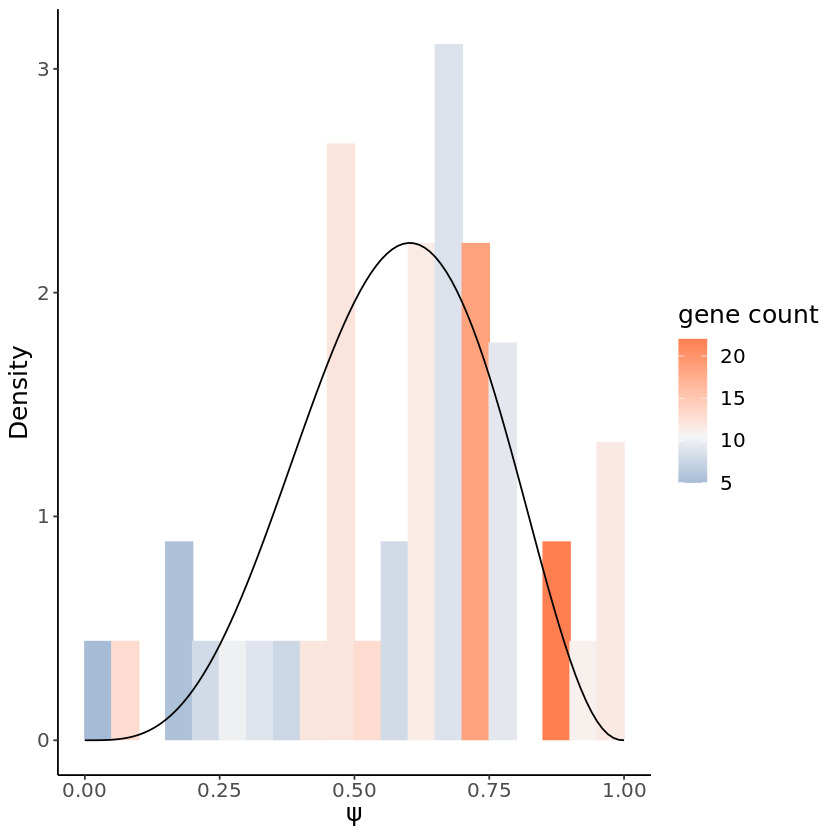

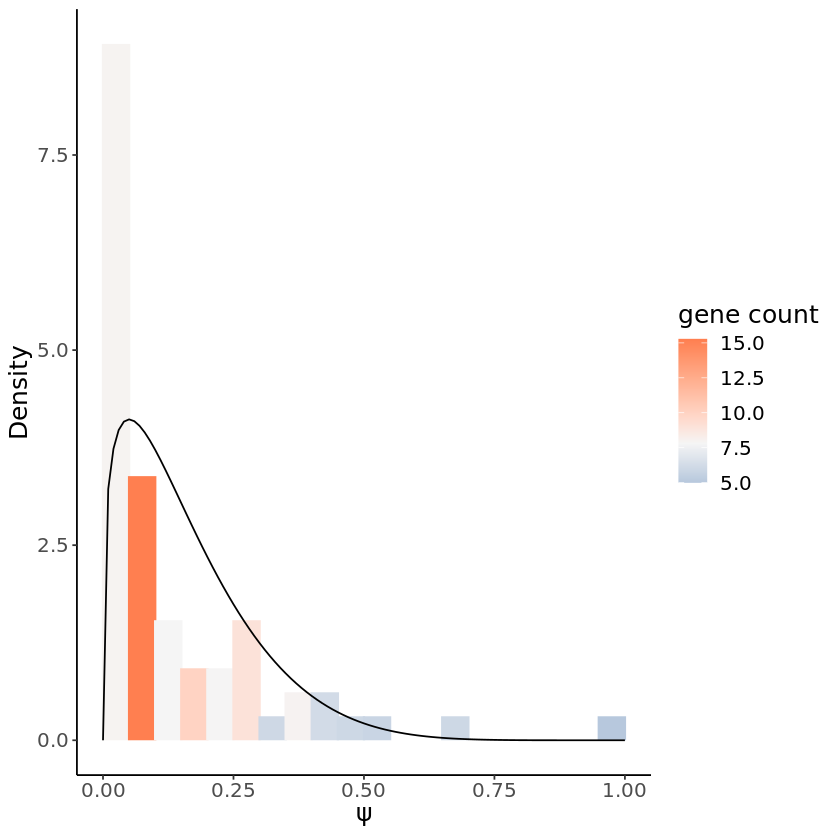

In [88]:
psiHist(crc,gene = "MYL6",exon = "35",group_col = "group",group = "epithelial",
           alpha = 4.585,beta = 3.364)
psiHist(crc,gene = "MYL6",exon = "35",group_col = "group",group = "immune",
            alpha = 1.296922,beta = 6.654382)

We could also check other genes, for example, RPS24:

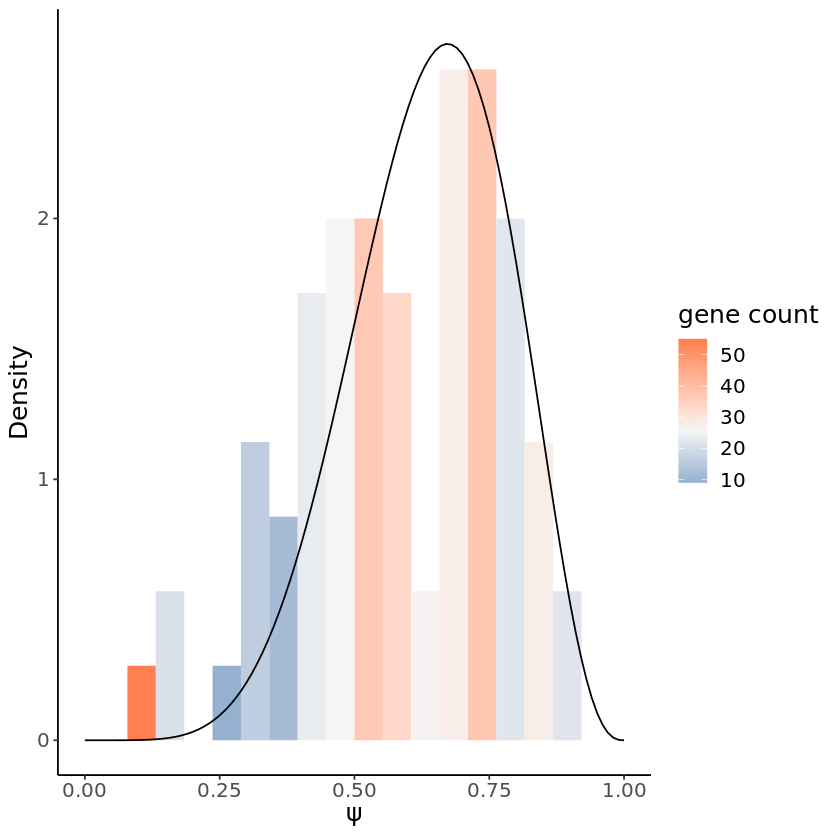

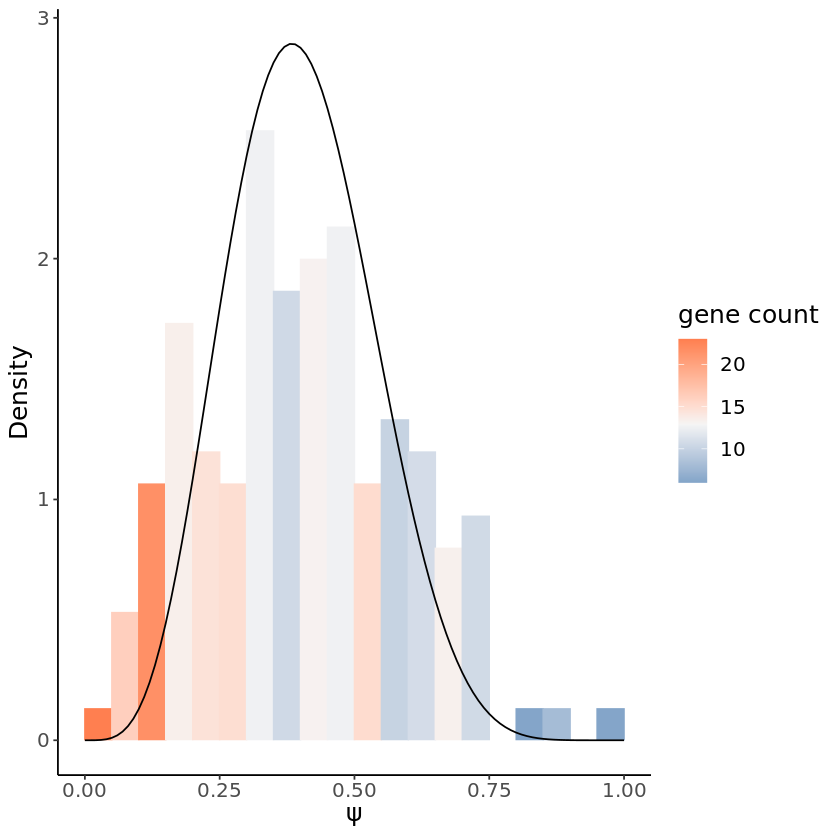

In [89]:
psiHist(crc,gene = "RPS24",exon = "31",group_col = "group",group = "epithelial",
           alpha = 6.683290,beta = 3.766842)
psiHist(crc,gene = "RPS24",exon = "31",group_col = "group",group = "immune",
            alpha = 5.211762,beta = 7.757096)